# Advanced Gradient Calculation of Variational Quantum Circuits

Translator: [unseenme](https://gitee.com/unseenme)

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/advanced/mindspore_get_gradient_of_PQC_with_mindquantum.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/advanced/mindspore_get_gradient_of_PQC_with_mindquantum.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/advanced/get_gradient_of_PQC_with_mindquantum.ipynb)

In MindSpore Quantum, we can obtain the gradient of a variable quantum circuit by the [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) method of the [Simulator](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html) class. In this tutorial, we will further introduce other functions of this method to help you achieve more advanced usage methods.

## Model Introduction

The [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) method is mainly used to calculate the value of the following expression and the gradient of the parameters in the circuit.

$$E(\boldsymbol{\theta})=\left<\varphi\right|U^\dagger_l(\boldsymbol{\theta})HU_r(\boldsymbol{\theta})\left|\psi\right>$$

The interface of this method is defined as

```python
Simulator.get_expectation_with_grad(
    hams,
    circ_right,
    circ_left=None,
    simulator_left=None,
    parallel_worker=None
)
```

Then, we will introduce the meaning of each parameter one by one.

1. `hams`. A single [Hamiltonian](https://www.mindspore.cn/mindquantum/docs/en/master/core/operators/mindquantum.core.operators.Hamiltonian.html) or a list of [Hamiltonian](https://www.mindspore.cn/mindquantum/docs/en/master/core/operators/mindquantum.core.operators.Hamiltonian.html)s. For the latter case, the framework will calculate the expected values of the circuit with respect to all Hamiltonians and the gradient of each expected value with respect to the circuit parameters at the same time.
2. `circ_right`. It is the $U_r(\boldsymbol{\theta})$ in the formula.
3. `circ_left`. It is the $U_l^\dagger(\boldsymbol{theta})$ in the formula. When it is the default value None, circ_left and circ_right are the same circuits. If empty lines are needed, they can be created separately using [Circuit()](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.Circuit.html).
4. `simulator_left`. It is the simulator that contains the $\left|\varphi\right>$ in the formula. You can set the state of the emulator to the state you need by the emulator's [set_qs](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.set_qs), [apply_gate](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_gate) or [apply_circuit](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_circuit) methods. When it is the default value None, $\left|\varphi\right>=\left|\psi\right>$, and $\left|\psi\right>$ is the quantum state contained in the current simulator.
5. `parallel_worker`. When the hams contains multiple Hamiltonians or the input of the encoder contains multiple sample points, MindSpore Quantum will reasonably perform parallel operations based on this integer as a reference.

In MindSpore Quantum, the parameters in a quantum circuit can be encoder parameters, which are used to encode classical data into quantum states, similar to the input part of a classical neural network. The encoder parameters accept a two-dimensional array, where the first dimension represents the number of samples, and the second dimension represents the number of features in the classical data, equivalent to a batch in classical machine learning. Another part of parameters can be ansatz parameters, similar to the training parameters in a classical neural network, used to train a specific quantum circuit. Below, we will construct a quantum circuit that contains both encoder and ansatz parameters.

In [1]:
from mindquantum.core.circuit import Circuit

circ1 = Circuit().rx('a', 0).as_encoder()       # Set quantum lines to encoder lines
circ2 = Circuit().ry('b', 0).as_ansatz()        # Set the quantum lines to ansatz lines. By default, all quantum lines are ansatz lines.
circ3 = Circuit().rz('c', 0).as_encoder()       # Set quantum lines to encoder lines

circ = circ1 + circ2 + circ3
print(f"encoder parameters: {circ.encoder_params_name}")
print(f"ansatz parameters: {circ.ansatz_params_name}")

encoder parameters: ['a', 'c']
ansatz parameters: ['b']


In the following we use MindSpore Quantum to calculate the expected value of the above quantum circuit with respect to the Hamiltonian $Z$. First, we define the problem Hamiltonian.

In [2]:
from mindquantum.core.operators import QubitOperator                   # Import QubitOperator module to generate bubble operators
from mindquantum.core.operators import Hamiltonian                     # Import Hamiltonian module to generate Hamiltonian

ham = Hamiltonian(QubitOperator('Z0'))
print(ham)

1 [Z0]


Next, we generate operators that compute the expected value and the derivative of the expected value with respect to each parameter.

In [3]:
from mindquantum.simulator import Simulator

sim = Simulator('mqvector', 1)
grad_ops = sim.get_expectation_with_grad(ham, circ)
print(grad_ops)

Here we compute the expected value of the quantum circuit with respect to the Pauli $Z$ operator for $a=1, b=2, c=3$. According to the above description, we choose encoder data as `[[1, 3]]`. The first dimension denotes the number of samples of classical data, and the second dimension denotes that there are two classical features, `a` and `c`. The value of trainable parameter $b$ is initialized as `[2]`.

In [4]:
import numpy as np

encoder_data = np.array([[1, 3]])
ansatz_data = np.array([2])
f, g_e, g_a = grad_ops(encoder_data, ansatz_data)
print(f"expectation value:\n{f}\n with shape {f.shape}")
print(
    f"gradient value w.r.t encoder parametres:\n{g_e}\n with shape {g_e.shape}")
print(
    f"gradient value w.r.t ansatz parametres:\n{g_a}\n with shape {g_a.shape}")

expectation value:
[[-0.2248451+0.j]]
 with shape (1, 1)
gradient value w.r.t encoder parametres:
[[[0.35017549+0.j 0.        +0.j]]]
 with shape (1, 1, 2)
gradient value w.r.t ansatz parametres:
[[[-0.4912955+0.j]]]
 with shape (1, 1, 1)


To verify that the encoder data can take different samples at the same time, we calculate the expectation and gradient for $a=1, c=3$ and $a=4, c=5$ at the same time.

In [5]:
encoder_data = np.array([[1, 3], [4, 5]])
ansatz_data = np.array([2])
f, g_e, g_a = grad_ops(encoder_data, ansatz_data)
print(f"expectation value:\n{f}\n with shape {f.shape}")
print(
    f"gradient value w.r.t encoder parametres:\n{g_e}\n with shape {g_e.shape}")
print(f"gradient value w.r.t ansatz parametres:\n{g_a}\n with shape {g_a.shape}")

expectation value:
[[-0.2248451 +0.j]
 [ 0.27201173+0.j]]
 with shape (2, 1)
gradient value w.r.t encoder parametres:
[[[ 0.35017549+0.j  0.        +0.j]]

 [[-0.31494096+0.j  0.        +0.j]]]
 with shape (2, 1, 2)
gradient value w.r.t ansatz parametres:
[[[-0.4912955 +0.j]]

 [[ 0.59435646+0.j]]]
 with shape (2, 1, 1)


### Result Analysis

In the above results, we find that the expectation result is a two-dimensional array with dimension $(2, 1)$. Here, the first dimension denotes the number of samples and the second dimension denotes the number of Hamiltonian. In MindSpore Quantum, we can calculate both the expected value of different Hamiltonian with respect to the line and the derivatives of the parameters, in addition to the sample points of the batch. Thus, in the above results, the expected value is $-0.2248451$ when $a=1, b=2, c=3$ and $0.27201173$ when $a=4, b=2, c=5$.

### Gradient Analysis

In the above results, we find that the gradient of the expected value about the encoder parameters is a three-dimensional array with dimension $(2, 1, 2)$, where the first dimension denotes the number of samples, the second dimension denotes the number of Hamiltonian, and the third dimension denotes the number of encoder parameters. The gradient of ansatz parameters is also a three-dimensional array with dimension $(2, 1, 1)$, where the first dimension denotes the number of samples, the second dimension denotes the number of Hamiltonian, and the third dimension denotes the number of ansatz parameters.

## Expected Values of Multiple Hamiltonians at Multiple Input Sample Points

In this task, we want to calculate the expected value of the Hamiltonian $Z_0, X_0, Y_0$ for the following quantum circuit when $\alpha=\text{arctan}(\sqrt{2}), \pi/2$.

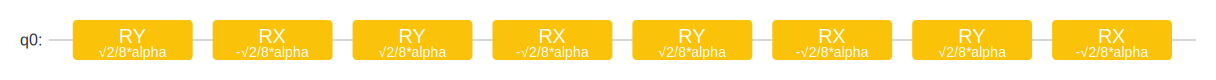

In [6]:
import numpy as np
from mindquantum.core.operators import QubitOperator, TimeEvolution, Hamiltonian
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit
from mindquantum.core.gates import H

# Define the axis of rotation in Hilbert space
axis = QubitOperator('Y0', 1 / np.sqrt(2)) + QubitOperator('X0', -1 / np.sqrt(2))
# Define the order of the trotter decomposition
trotter_order = 4
# Trotter decomposition of rotation using TimeEvolution
encoder = TimeEvolution(axis, {'alpha': 0.5 / trotter_order}).circuit * trotter_order
encoder.as_encoder()
encoder.svg()

Next, define the Hamiltonian of the expected value to be calculated:

In [7]:
# Define the Hamiltonian Set
hams = [Hamiltonian(QubitOperator('X0')), Hamiltonian(QubitOperator('Y0')), Hamiltonian(QubitOperator('Z0'))]
hams

[1 [X0], 1 [Y0], 1 [Z0]]

Get the operator for the expected value and gradient:

In [8]:
grad_ops = Simulator('mqvector', 1).get_expectation_with_grad(hams, encoder, parallel_worker=6)
grad_ops

Define the value of alpha:

In [9]:
alpha = np.array([[np.arctan(np.sqrt(2))], [np.pi/2]])
alpha

array([[0.95531662],
       [1.57079633]])

In [10]:
f, g = grad_ops(alpha)
print(f)
print(f'shape: {f.shape}')
print('\n')
print(g)
print(f'shape: {g.shape}')

[[0.59389047+0.00000000e+00j 0.55828416+1.38777878e-17j
  0.57932107+0.00000000e+00j]
 [0.77269648+0.00000000e+00j 0.63465887-1.38777878e-17j
  0.01217645+0.00000000e+00j]]
shape: (2, 3)


[[[ 0.45790207+0.j]
  [ 0.35200884+0.j]
  [-0.80864423+0.j]]

 [[ 0.10989151+0.j]
  [-0.11512098+0.j]
  [-0.9732094 +0.j]]]
shape: (2, 3, 1)


### Result Analysis

According to the above results, we can see that the dimension of the expected value f is $(2, 3)$. It is not difficult to find that each row of f corresponds to a different expected value of the Hamiltonian for each sample point, and each column of `f` corresponds to the expected value of each Hamiltonian under different samples. For the gradient `g`, we also have similar conclusions, except that the last dimension represents different circuit parameters.

## Calculating the Inner Product of Different Quantum States

According to the model, we only need to set the Hamiltonian to an unit operator and $U_l(\boldsymbol{\theta})$ to an empty quantum circuit, then we can use $U_r(\boldsymbol{\theta})$ to rotate $\left|\psi\right>$ to $\left|\varphi\right>$, which requires calculating the inner product between $\left|\varphi\right>$ and the rotated quantum state.

Here, we compute the inner product between the quantum state after the evolution of the zero state by the following quantum circuit and the uniform superposition.

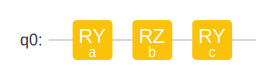

In [11]:
circuit = Circuit().ry('a', 0).rz('b', 0).ry('c', 0)
circuit.svg()

Prepare a simulator containing uniform superposition states:

In [12]:
sim_l = Simulator('mqvector', 1)
sim_l.apply_gate(H.on(0))
sim_l

mqvector simulator with 1 qubit (little endian), dtype: mindquantum.complex128.
Current quantum state:
√2/2¦0⟩
√2/2¦1⟩

Prepare the unit Hamiltonian:

In [13]:
ham = Hamiltonian(QubitOperator(""))

Get the inner product and gradient computation operators:

In [14]:
grad_ops = Simulator('mqvector', 1).get_expectation_with_grad(ham, circuit, Circuit(), simulator_left=sim_l)

Choose the appropriate parameters:

In [15]:
rot_angle = np.array([7.902762e-01, 2.139225e-04, 7.795934e-01])
f, g = grad_ops(rot_angle)
print(f)
print('\n')
print(g)

[[0.99999989-7.52279618e-05j]]


[[[ 2.31681689e-04+3.80179652e-05j -5.34806192e-05-3.51659884e-01j
    2.31681689e-04-3.80179652e-05j]]]


### Result Analysis

According to the calculation results, we find that the inner product of the last two states is close to 1, indicating that we can prepare a uniform superposition state with high fidelity by the above circuit $\left(\left|0\right> + \left|1\right>\right)/\sqrt{2}$.

In [16]:
print(circuit.get_qs(pr=rot_angle, ket=True))

(0.7074343486186319-0.00010695972396782116j)¦0⟩
(0.7067790538448511+√5/3906250j)¦1⟩


In [17]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Sun Dec 31 22:58:30 2023
